# Premier League ELO Rankings | 1993/94 - 2021/22

This project will attempt to create an ELO ranking system for all premier league teams based on their results since the 1993/94 season. This dataset has been downloaded from kaggle (https://www.kaggle.com/datasets/irkaal/english-premier-league-results), and features no in depth stats before the 2000/01 season as these were not recorded beforehand. However, all that this system needs to function is the two teams playing and which team won (in this case: HomeTeam, AwayTeam and FTR). All teams will be given a base ELO of 800, and this value will change as would be expected in an ELO based ranking system.

The End goal is to provide a graph of the changes in ELO for each team, which will then be able to tell us interesting facts such as the best team in the last 20 years (will this be the Invincible Arsenal, Treble Winning Man Utd or Centurion Man City?), the worst team in the last 20 years, the times teams beat the ELO System (Leicster 2016?), and the rise and fall of certain teams (Man Utd, Arsenal, Blackburn, Notts Forrest). Obviously, this model will have some flaws, as it may become heavily biased towards the higher end teams, and may not make very accurate predictions as football is more than just recent form, but it should be interesting nonetheless.

In [300]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import math
import datetime
from datetime import datetime
import re

In [301]:
#turn the csv file into a dataframe
results = pd.read_csv("premierLeagueResults.csv", encoding = "Latin-1")

## Data Inspection and Organisation

In [433]:
print(results.head())

    Season              DateTime     HomeTeam        AwayTeam  FTHG  FTAG FTR  \
0  1993-94  1993-08-14T00:00:00Z      Arsenal        Coventry     0     3   A   
1  1993-94  1993-08-14T00:00:00Z  Aston Villa             QPR     4     1   H   
2  1993-94  1993-08-14T00:00:00Z      Chelsea       Blackburn     1     2   A   
3  1993-94  1993-08-14T00:00:00Z    Liverpool  Sheffield Weds     2     0   H   
4  1993-94  1993-08-14T00:00:00Z     Man City           Leeds     1     1   D   

   HTHG  HTAG  HTR  ... HST  AST  HC  AC  HF  AF  HY  AY  HR  AR  
0   NaN   NaN  NaN  ... NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  
1   NaN   NaN  NaN  ... NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  
2   NaN   NaN  NaN  ... NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  
3   NaN   NaN  NaN  ... NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  
4   NaN   NaN  NaN  ... NaN  NaN NaN NaN NaN NaN NaN NaN NaN NaN  

[5 rows x 23 columns]


In [434]:
print(results.columns)

Index(['Season', 'DateTime', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR',
       'HTHG', 'HTAG', 'HTR', 'Referee', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC',
       'HF', 'AF', 'HY', 'AY', 'HR', 'AR'],
      dtype='object')


In [435]:
print(results.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11113 entries, 0 to 11112
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Season    11113 non-null  object 
 1   DateTime  11113 non-null  object 
 2   HomeTeam  11113 non-null  object 
 3   AwayTeam  11113 non-null  object 
 4   FTHG      11113 non-null  int64  
 5   FTAG      11113 non-null  int64  
 6   FTR       11113 non-null  object 
 7   HTHG      10189 non-null  float64
 8   HTAG      10189 non-null  float64
 9   HTR       10189 non-null  object 
 10  Referee   8289 non-null   object 
 11  HS        8289 non-null   float64
 12  AS        8289 non-null   float64
 13  HST       8289 non-null   float64
 14  AST       8289 non-null   float64
 15  HC        8289 non-null   float64
 16  AC        8289 non-null   float64
 17  HF        8289 non-null   float64
 18  AF        8289 non-null   float64
 19  HY        8289 non-null   float64
 20  AY        8289 non-null   fl

In [436]:
#setting up the ELO base values
matchDataHome = list(results.HomeTeam)
matchDataAway = list(results.AwayTeam)
matchDataFTR = list(results.FTR)
matchDataDate = (results['DateTime'].str.extract(r'(\d{4}-\d{2}-\d{2})')).values.tolist()



allTeams = results['HomeTeam'].unique()

eloDictionary = dict.fromkeys(allTeams, 800)

#these lists must be immutable
eloAllTime = {k:[] for k in allTeams}
allDates = {k:[] for k in allTeams}



In [437]:
#generating the expected results - higher ranked team has higher probability of winning
def expectedResults(homeTeam, awayTeam):
    homeRating = eloDictionary[homeTeam]
    awayRating = eloDictionary[awayTeam]
    ratingDiff = homeRating - awayRating
    expectedResult = (1 / (10 ** (-ratingDiff/800)+1))
    
    return [np.round(expectedResult,3), 1 - np.round(expectedResult,3)]

#generating actual result using the FTR field
def actualResult(team1, team2, FTR):
    homeTeam = 0.5
    awayTeam = 0.5
    if FTR == 'H':
        homeTeam = 1
        awayTeam = 0
    elif FTR == 'A':
        homeTeam = 0
        awayTeam = 1
        
    return [homeTeam, awayTeam]

#updating the new elo
def calculateElo(expected, actual, elo, k = 80):
    
    newElo = elo + (k * (actual - expected))
    
    
    return newElo    
    
def gameDay(homeTeam, awayTeam, FTR):
    expected = expectedResults(homeTeam, awayTeam)
    actual = actualResult(homeTeam, awayTeam, FTR)
    
    
    #home team elo update
    eloDictionary[homeTeam] = int(calculateElo(expected[0], actual[0], eloDictionary[homeTeam]))
    
    
    #away team elo update
    eloDictionary[awayTeam] = round(calculateElo(expected[1], actual[1], eloDictionary[awayTeam]))
    
    
    #to see how accurate expectedResult is
    expected = expected[0]
    numRight = 0
    if expected < 0.501 and expected > 0.499:
        if FTR == 'T':
            numRight += 1
    elif expected > 0.501:
        if FTR == 'H':
            numRight += 1
    elif expected < 0.499:
        if FTR == 'A':
            numRight += 1
    return numRight


In [438]:
wasCorrect = 0
for i in range(len(matchDataHome)):
    wasCorrect += gameDay(matchDataHome[i], matchDataAway[i], matchDataFTR[i])  
    eloAllTime[matchDataHome[i]].append(eloDictionary[matchDataHome[i]])  
    eloAllTime[matchDataAway[i]].append(eloDictionary[matchDataAway[i]])
    allDates[matchDataHome[i]].append(matchDataDate[i])
    allDates[matchDataAway[i]].append(matchDataDate[i]) 
    
print(f"was correct {(np.round(wasCorrect/len(matchDataHome), 3)) * 100}% of the time.")  


was correct 48.8% of the time.


## ELO Analysis

### Arsenal FC

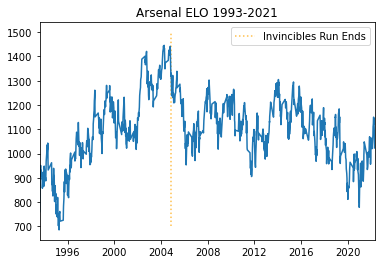

In [440]:
ArsenalDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Arsenal']]
plt.plot(ArsenalDateObjects, eloAllTime['Arsenal'])
plt.vlines(datetime.strptime('2004-10-24', '%Y-%m-%d').date(), 700, 1500, color='orange', linestyle='dotted',
           alpha=0.7, label='Invincibles Run Ends')
plt.title('Arsenal ELO 1993-2021')
plt.legend()
plt.xlim(min(ArsenalDateObjects), max(ArsenalDateObjects))
plt.show()

As an Arsenal fan, these results are disappointing. This graph clearly shows the rise of Arsene Wenger, culminating in the 49 game unbeaten run of the invincible Arsenal side, before showing a decline to an above average, but not title challenging, club. On the later end of the graph, the data shows what we have been feeling - a decline to an almost mid table club, but perhaps with some hope following an upturn of the level of performances in the end of the 2020/21 season thanks to Mikel Arteta.

### Manchester United FC

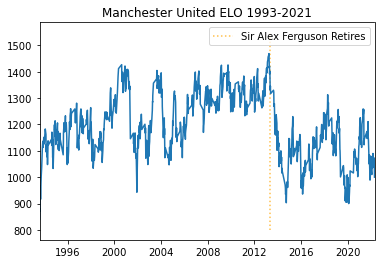

In [442]:
ManUtdDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Man United']]
plt.plot(ManUtdDateObjects, eloAllTime['Man United'])
plt.vlines(datetime.strptime('2013-05-08', '%Y-%m-%d').date(), 800, 1550, color='orange', linestyle='dotted', 
           alpha=0.7, label='Sir Alex Ferguson Retires')
plt.title('Manchester United ELO 1993-2021')
plt.legend()
plt.xlim(min(ManUtdDateObjects), max(ManUtdDateObjects))
plt.show()

The Manchester United graph paints a different picture. One that we have all felt. 2 decades of sheer dominance, spearheaded by the greatest Premier league manager of all time. Once he retired, Manchester United lost everything, plummeting down season after season, unable to find a manager to take them back to previous heights. Whether the club will be fixed with the arrival of Erik Ten Hag remains to be seen.

### Chelsea FC

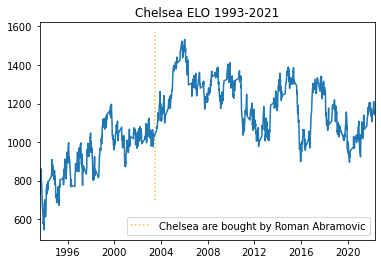

In [445]:
ChelseaDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Chelsea']]
plt.plot(ChelseaDateObjects, eloAllTime['Chelsea'])
plt.vlines(datetime.strptime('2003-07-02', '%Y-%m-%d').date(), 700, 1570, color='orange', linestyle='dotted', 
           alpha=0.7, label='Chelsea are bought by Roman Abramovic')
plt.title('Chelsea ELO 1993-2021')
plt.legend()
plt.xlim(min(ChelseaDateObjects), max(ChelseaDateObjects))
plt.show()

The graph for Chelsea is an interesting one. A stabilisation at a midtable level exploded once Roman Abramovic bought the club, ushering in an era of large scale achievement, including League Titles, FA Cups and Champions League Titles. To see how the club continues in a post Abramovic era will be an interesting watch.

### Manchester City FC

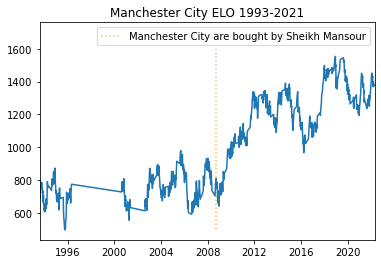

In [447]:
ManCityDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Man City']]
plt.plot(ManCityDateObjects, eloAllTime['Man City'])
plt.vlines(datetime.strptime('2008-09-01', '%Y-%m-%d').date(), 500, 1700, color='orange', linestyle='dotted', 
           alpha=0.7, label='Manchester City are bought by Sheikh Mansour')
plt.title('Manchester City ELO 1993-2021')
plt.legend()
plt.xlim(min(ArsenalDateObjects), max(ArsenalDateObjects))
plt.show()

Manchester City were nothing before Sheikh Mansour. Drowning in the shadow of the (**then?**) larger Manchester United, City would see themselves relegated from the premier league twice, the only club from the 'Big 6' to have done so in the past 20 years. And then, quite like Chelsea, once the money came in, an explosion of achievement happened. Premier League titles and domestic domination was something unthinkable for pre 2008 City fans, and yet here it is. Whether City will win a European title and cement themselves amongst the biggest clubs in Europe remains to be seen.

### Liverpool FC

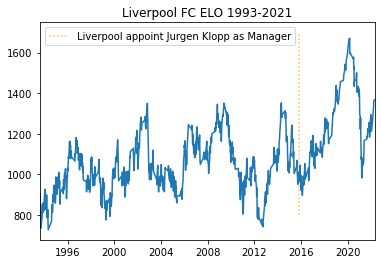

In [314]:
LiverpoolDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Liverpool']]
plt.plot(LiverpoolDateObjects, eloAllTime['Liverpool'])
plt.vlines(datetime.strptime('2015-10-09', '%Y-%m-%d').date(), 800, 1700, color='orange', linestyle='dotted', 
           alpha=0.7, label='Liverpool appoint Jurgen Klopp as Manager')
plt.title('Liverpool FC ELO 1993-2021')
plt.legend()
plt.xlim(min(LiverpoolDateObjects), max(LiverpoolDateObjects))
plt.show()

The graph for Liverpool is perhaps not quite long enough to do them justice. A club massive in the times before this dataset recorded, it shows them as a massively inconsistent  side - which in all fairness, they were. This all changed with the arrival of Jurgen Klopp from Borussia Dortmund, who has since ushered in a level of achievement not seen in years at Liverpool. This Jurgen Klopp Liverpool side also hold the prize of the highest ELO in this analysis, beating out the likes of treble winning Manchester United, centurion Manchester City and invincible Arsenal, despite only having won 1 league title - showing just how consistently good they have been, and perhaps how unlucky to have not won more.

### Tottenham Hotspur FC

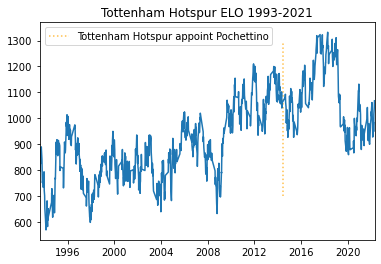

In [315]:
SpursDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Tottenham']]
plt.plot(SpursDateObjects, eloAllTime['Tottenham'])
plt.vlines(datetime.strptime('2014-05-27', '%Y-%m-%d').date(), 700, 1300, color='orange', linestyle='dotted',
           alpha=0.7, label='Tottenham Hotspur appoint Pochettino')
plt.title('Tottenham Hotspur ELO 1993-2021')
plt.legend()
plt.xlim(min(SpursDateObjects), max(SpursDateObjects))
plt.show()

From an unbiased perspective, Tottenham Hotspur are the smallest team in the 'Big 6'. A mid table team that have since solidified to become above average, possibly even good, Tottenham Hotspur's best era has taken place under Mauricio Pochettino, yet they have still been left trophyless and without a proper title race, save perhaps a 3 way battle with Leicester and Arsenal in the 2015/16 league. However, with a brand new beautiful stadium and the knowing leadership of serial winner Antonio Conte, perhaps they will finally clean the dust from their trophy cabinet and give their fans a foot to stand on in debates with rival fans. 

(All of these are jokes, I love Spurs fans dearly)

### Leicester City

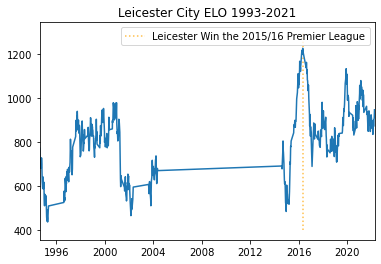

In [316]:
LeicesterDateObjects = [datetime.strptime(date[0], '%Y-%m-%d').date() for date in allDates['Leicester']]
plt.plot(LeicesterDateObjects, eloAllTime['Leicester'])
plt.vlines(datetime.strptime('2016-05-27', '%Y-%m-%d').date(), 400, 1300, color='orange', linestyle='dotted', 
           alpha=0.7, label = 'Leicester Win the 2015/16 Premier League')
plt.title('Leicester City ELO 1993-2021')
plt.legend()
plt.xlim(min(LeicesterDateObjects), max(LeicesterDateObjects))
plt.show()

In an incredible season that epitomized why we love the beautiful game, 2015/16 Leicester broke this ELO system and caused the steepest rise in ELO out of all the teams in this dataset. Having almost been relegated the season before, Leicester pulled off the most incredible League title of all time, and have since cemented themselves as an upper mid-table team. To see how they progress will be interesting.

## All time Ranking - as of the end of the 2021/22 Season

In [317]:
sortAllTeams = dict(sorted(eloDictionary.items(),key= lambda x: -x[1]))
i = 1
for key, value in sortAllTeams.items():
    print(i, ':', key)
    i += 1

1 : Man City
2 : Liverpool
3 : Chelsea
4 : Tottenham
5 : Arsenal
6 : Man United
7 : Leicester
8 : West Ham
9 : Wolves
10 : Newcastle
11 : Crystal Palace
12 : Brentford
13 : Leeds
14 : Southampton
15 : Brighton
16 : Aston Villa
17 : Wigan
18 : Ipswich
19 : Bolton
20 : Blackpool
21 : Charlton
22 : Birmingham
23 : Sheffield Weds
24 : Stoke
25 : Oldham
26 : Coventry
27 : Everton
28 : Burnley
29 : Barnsley
30 : Nott'm Forest
31 : Swansea
32 : Bournemouth
33 : Hull
34 : Cardiff
35 : Portsmouth
36 : Blackburn
37 : Swindon
38 : West Brom
39 : Bradford
40 : Sheffield United
41 : Reading
42 : Fulham
43 : QPR
44 : Wimbledon
45 : Middlesbrough
46 : Watford
47 : Sunderland
48 : Norwich
49 : Huddersfield
50 : Derby


## 2022/23 Season Predicitions

In [320]:
nextSeasonTeams = ['Arsenal', 'Aston Villa', 'Chelsea', 'Liverpool', 'Man City', 'Newcastle', 'Southampton', 
'West Ham', 'Tottenham', 'Everton', 'Leeds', 'Man United', 'Crystal Palace', 'Leicester', "Nott'm Forest", 'Fulham',
'Wolves', 'Bournemouth', 'Brighton', 'Brentford']

nextSeasonTeamsELO = []
for i in nextSeasonTeams:
    nextSeasonTeamsELO.append((eloDictionary[i]))
    
nextSeasonDict = {nextSeasonTeams[k]:nextSeasonTeamsELO[k] for k in range(20)}


sortedTeams=dict(sorted(nextSeasonDict.items(),key= lambda x: -x[1]))

i = 1
for key, value in sortedTeams.items():
    print(i, ':', key, round((value / 100 * 9) - 31))
    i += 1

1 : Man City 93
2 : Liverpool 92
3 : Chelsea 74
4 : Tottenham 65
5 : Arsenal 61
6 : Man United 59
7 : Leicester 54
8 : West Ham 50
9 : Wolves 46
10 : Newcastle 44
11 : Crystal Palace 44
12 : Brentford 38
13 : Leeds 36
14 : Southampton 36
15 : Brighton 35
16 : Aston Villa 34
17 : Everton 25
18 : Nott'm Forest 25
19 : Bournemouth 23
20 : Fulham 17


These results are based solely on the form of the teams at the end of last season. In order to make a more accurate simulation, running the probability function with a MonteCarlo number generator to account for unexpected wins would be a more accurate simulation. I will carry this out at some point in the future, when I have more time.

0.446
Draw
